# **Comparative Analysis of some Machine Learning Techniques used in model-based Collaborative Filtering Recommender Systems (CF-RS)**

## **0. Setup**

**Dependencies installation**

In [ ]:
### Install required dependencies

# Run only this 'pip install' first (then, say Yes to restart session)
#!pip install numpy==1.23.5 --force-reinstall

# Run this 'pip install' after the session has restarted
#!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2461560 sha256=12fcda3bc368fca21eeb9b3300d5783648b88eeb901b4637bd1c6808cacffa1a
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


**Imports**

In [ ]:
# Import surprise for rating prediction models
from surprise import Dataset, Reader, SVD, NMF, accuracy
from surprise.model_selection import train_test_split, RandomizedSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import pairwise_distances

# For top-N evaluation
from collections import defaultdict

**Load MovieLens 1M dataset and split into train/test subsets**

In [ ]:
data = Dataset.load_builtin('ml-1m')
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

**Additional functions**

In [ ]:
# To display correctly the time "... min ... sec"
def display_elapsed_time(elapsed_time):
  if elapsed_time < 60:
    return(f"{round(elapsed_time, 2)} seconds")
  else:
    minutes = int(elapsed_time // 60
                  )
    seconds = round(elapsed_time % 60, 2)
    return(f"{minutes} min {seconds} sec")

In [ ]:
# To calculate the sparsity of a matrix
def calculate_sparsity_of(matrix):
    num_users = matrix.shape[0]
    num_items = matrix.shape[1]
    num_ratings = matrix.count().sum()

    sparsity = 1 - (num_ratings / (num_users * num_items))
    sparsity = sparsity * 100
    return sparsity

## **1. Dimensionality Reduction Approaches (SVD and NMF)**

https://surprise.readthedocs.io/en/stable/matrix_factorization.html

### **1.1 SVD (Singular Value Decomposition)**

*Find the optimal parameters through a Randomized Search*

In [ ]:
# Grid of parameters to search
param_grid = {
    'n_factors': [50, 100, 150],      # Number of latent factors (dimensionality of the SVD)
    'lr_all': [0.001, 0.005, 0.01],   # Learning rate for all parameters
    'reg_all': [0.01, 0.02, 0.05]     # Regularization term for all parameters
}

# Initialize RandomizedSearchCV with SVD model
rs_svd = RandomizedSearchCV(
    SVD,                    # Algorithm to tune
    param_grid,             # Hyperparameter space
    n_iter=10,              # Number of parameter combinations to try
    measures=['mae'],       # Metrics to evaluate
    cv=3,                   # 3-fold cross-validation
    random_state=42         # For reproducibility
)

start = time.time() # Used to measure the time taken to train the model
rs_svd.fit(data)    # Fitting on the dataset
svd_training_time = time.time() - start # Calculate training duration


In [ ]:
print("SVD training time: ", display_elapsed_time(svd_training_time))
print("----------------------------------")
print("Best MAE:", rs_svd.best_score['mae'])
print("Best Params for best MAE:", rs_svd.best_params['mae'])

*Create the optimized model: rs_svd_opt*

In [ ]:
rs_svd_opt = SVD(**rs_svd.best_params['mae'], random_state=42)

# Fit it on the training set
start = time.time()
rs_svd_opt.fit(trainset)
svd_opt_training_time = time.time() - start
print("SVD training time: ", display_elapsed_time(svd_opt_training_time))

### **1.2 NMF (Non-Negative Matrix Factorisation)**

*Find the optimal parameters through a Randomized Search*

In [ ]:
param_grid = {
    'n_factors': [10, 20, 30, 40],
    'reg_pu': [0.04, 0.06, 0.1],
    'reg_qi': [0.04, 0.06, 0.1],
    'reg_bu': [0.04, 0.06, 0.1],
    'reg_bi': [0.04, 0.06, 0.1],
    'lr_bu': [0.002, 0.005, 0.01],
    'lr_bi': [0.002, 0.005, 0.01],
    'biased': [True]
}

rs_nmf = RandomizedSearchCV(NMF, param_grid, n_iter=10, measures=['mae'], cv=3, random_state=42)

start = time.time()
rs_nmf.fit(data)
nmf_training_time = time.time() - start


In [ ]:
print("NMF training time: ", display_elapsed_time(nmf_training_time))
print("----------------------------------")
print("Best MAE:", rs_nmf.best_score['mae'])
print("Best Params for best MAE:", rs_nmf.best_params['mae'])

*Create the optimized model: rs_nmf_opt*

In [ ]:
rs_nmf_opt = NMF(**rs_nmf.best_params['mae'], random_state=42)

# Fit it on the training set
start = time.time()
rs_nmf_opt.fit(trainset)
nmf_opt_training_time = time.time() - start
print("NMF training time: ", display_elapsed_time(nmf_opt_training_time))

### **1.3 Ratings prediction evaluation (MAE and RMSE)**

In [ ]:
predictions_svd = rs_svd_opt.test(testset)
predictions_nmf = rs_nmf_opt.test(testset)

predictions_all = [
    ("SVD", predictions_svd),
    ("NMF", predictions_nmf),
]


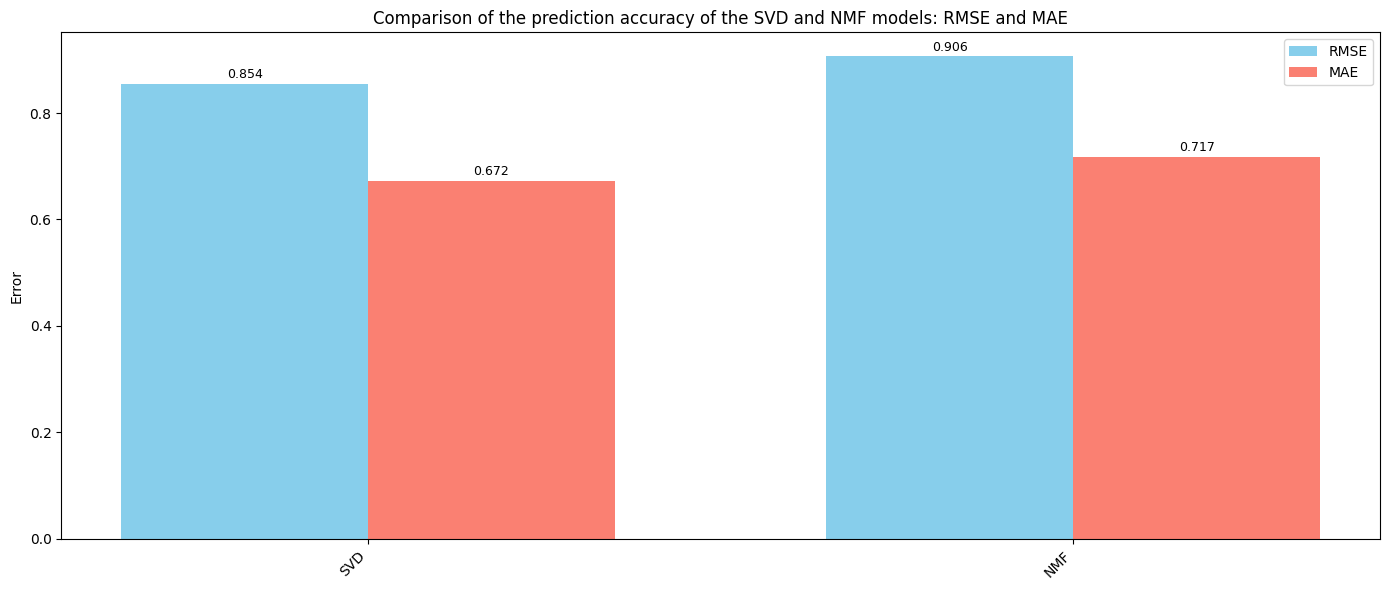

In [ ]:
def display_rmse_mae_comparison(predictions):
  # Compute RMSE and MAE
  rmse_scores = [accuracy.rmse(pred, verbose=False) for _, pred in predictions]
  mae_scores = [accuracy.mae(pred, verbose=False) for _, pred in predictions]
  model_names = [name for name, _ in predictions]

  # Plot settings
  x = np.arange(len(model_names))  # label locations
  width = 0.35  # width of bars

  fig, ax = plt.subplots(figsize=(14, 6))
  bars1 = ax.bar(x - width/2, rmse_scores, width, label='RMSE', color='skyblue')
  bars2 = ax.bar(x + width/2, mae_scores, width, label='MAE', color='salmon')

  # Add value labels on top of bars
  for bar in bars1:
      height = bar.get_height()
      ax.annotate(f'{height:.3f}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 2),  # vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=9)

  for bar in bars2:
      height = bar.get_height()
      ax.annotate(f'{height:.3f}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 2),
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=9)

  # Labels and titles
  ax.set_ylabel('Error')
  ax.set_title('Comparison of the prediction accuracy of the SVD and NMF models: RMSE and MAE')
  ax.set_xticks(x)
  ax.set_xticklabels(model_names, rotation=45, ha='right')
  ax.legend()
  plt.tight_layout()
  plt.show()

display_rmse_mae_comparison(predictions_all)

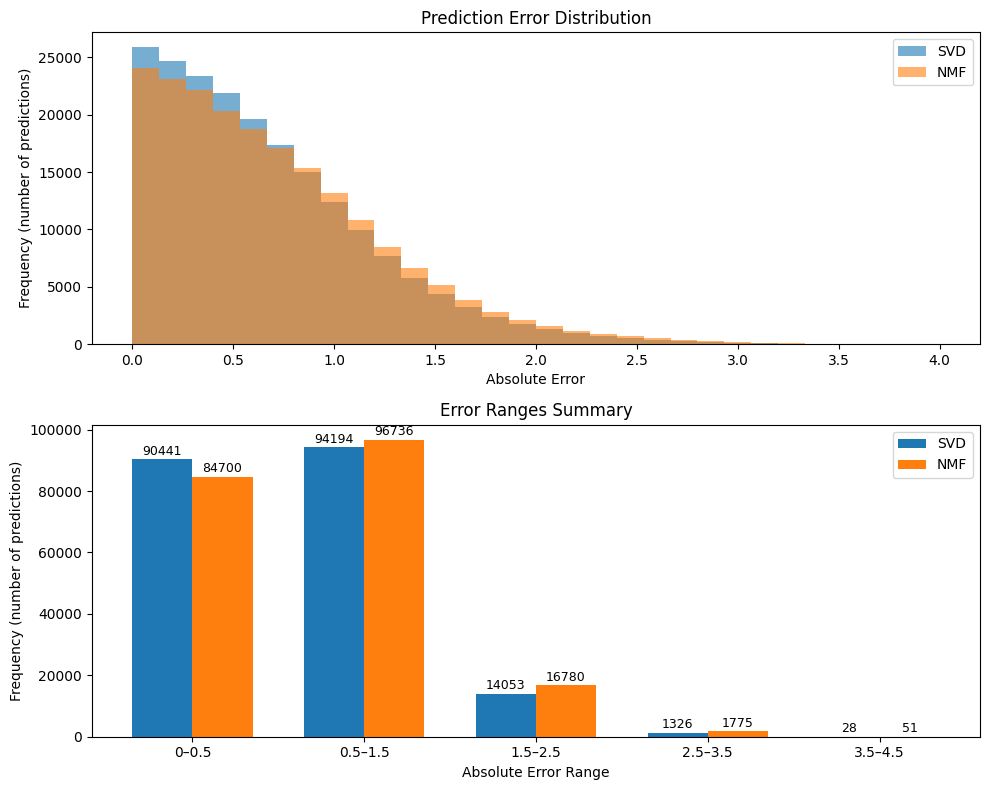

In [ ]:
def plot_error_distribution_comparison(predictions_svd, predictions_nmf):
    errors_svd = [abs(true_r - est) for (_, _, true_r, est, _) in predictions_svd]
    errors_nmf = [abs(true_r - est) for (_, _, true_r, est, _) in predictions_nmf]

    # Define wider error bins for summary
    bin_edges = [0, 0.5, 1.5, 2.5, 3.5, 4.5]
    bin_labels = ["0–0.5", "0.5–1.5", "1.5–2.5", "2.5–3.5", "3.5–4.5"]

    def bin_error_counts(errors, bins):
        counts = np.histogram(errors, bins=bins)[0]
        return counts

    svd_counts = bin_error_counts(errors_svd, bin_edges)
    nmf_counts = bin_error_counts(errors_nmf, bin_edges)

    x = np.arange(len(bin_labels))  # X locations for the bars
    width = 0.35

    fig, axs = plt.subplots(2, 1, figsize=(10, 8
                                          ))

    # Subplot 1: Detailed histogram
    axs[0].hist(errors_svd, bins=30, alpha=0.6, label="SVD")
    axs[0].hist(errors_nmf, bins=30, alpha=0.6, label="NMF")
    axs[0].set_xlabel("Absolute Error")
    axs[0].set_ylabel("Frequency (number of predictions)")
    axs[0].set_title("Prediction Error Distribution")
    axs[0].legend()

    # Subplot 2: Summary error ranges
    bars_svd = axs[1].bar(x - width/2, svd_counts, width, label='SVD')
    bars_nmf = axs[1].bar(x + width/2, nmf_counts, width, label='NMF')

    # Add value labels
    for bar in bars_svd:
        height = bar.get_height()
        axs[1].annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 1),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    for bar in bars_nmf:
        height = bar.get_height()
        axs[1].annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 1),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    axs[1].set_xticks(x)
    axs[1].set_xticklabels(bin_labels)
    axs[1].set_xlabel("Absolute Error Range")
    axs[1].set_ylabel("Frequency (number of predictions)")
    axs[1].set_title("Error Ranges Summary")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_error_distribution_comparison(predictions_svd, predictions_nmf)


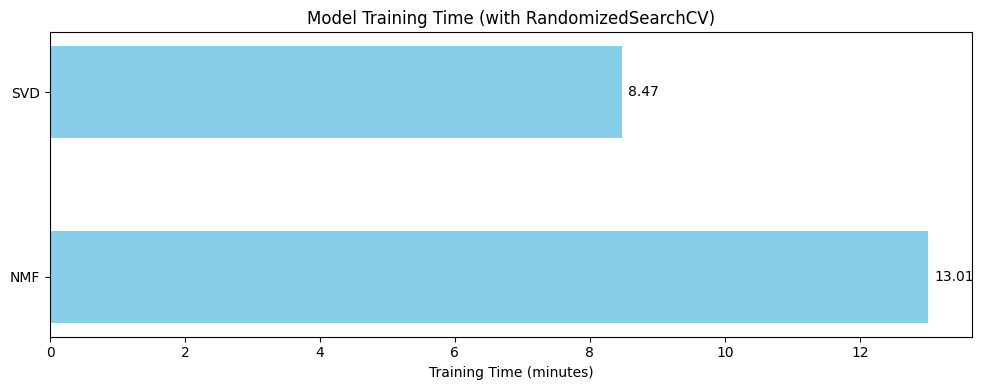

In [ ]:
model_names = ['SVD', 'NMF']
training_times = [svd_training_time, nmf_training_time]
training_times_min = [t / 60 for t in training_times]

plt.figure(figsize=(10, 4))
bar_height = 0.5
bars = plt.barh(model_names, training_times_min, color='skyblue', height=bar_height)
plt.xlabel("Training Time (minutes)")
plt.title("Model Training Time (with RandomizedSearchCV)")
plt.gca().invert_yaxis()

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height() / 2,
             f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()

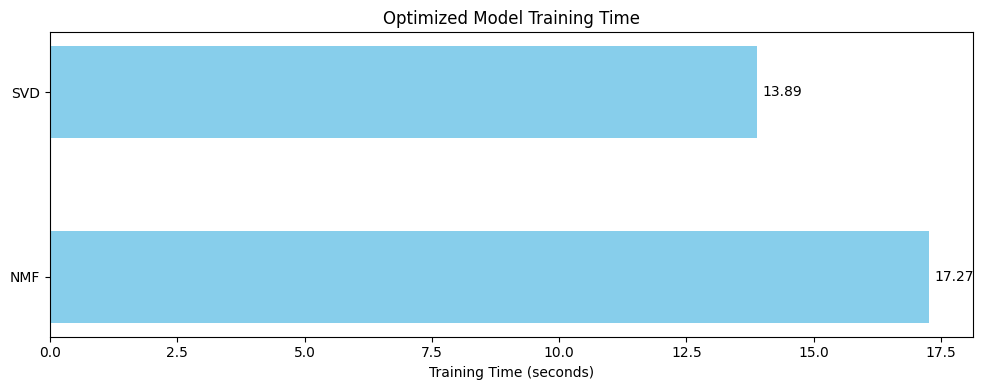

In [ ]:
model_names = ['SVD', 'NMF']
training_times = [svd_opt_training_time, nmf_opt_training_time]

plt.figure(figsize=(10, 4))
bar_height = 0.5
bars = plt.barh(model_names, training_times, color='skyblue', height=bar_height)
plt.xlabel("Training Time (seconds)")
plt.title("Optimized Model Training Time")
plt.gca().invert_yaxis()

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height() / 2,
             f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()

### **1.4 Observations**


In this experiment, both models have comparable prediction accuracy but SVD does outperform NMF for the accuracy metrics RMSE and MAE.

SVD offers a good balance between prediction accuracy and efficiency. This makes it more favorable than NMF which longer training time might limit its practical use in scenarios requiring fast deployment and larger datasets.

These results are based on the current relatively basic implementations of SVD and NMF. So, these findings may not apply universally accross all types of models or datasets.

## **2. Clustering-Based approach: K-means**

### **Pre-processing (train/test split and filling of the training matrix)**

In [ ]:
# Convert trainset and testset to DataFrame
train_df = pd.DataFrame(trainset.build_testset(), columns=['userId', 'itemId', 'rating'])
test_df = pd.DataFrame(testset, columns=['userId', 'itemId', 'rating'])

## To check if all test users are in the training set
train_users = set(train_df['userId'].unique()) # Extract unique user IDs from trainset
print("How many users in the training set? ", len(list(train_users)))
test_users = set(test_df['userId'].unique()) # Extract unique user IDs from testset
print("How many users in the testing set? ", len(list(test_users)))
all_test_users_in_train = test_users.issubset(train_users)
print("Are all test users in the training set?", all_test_users_in_train)


How many users in the training set?  6040
How many users in the testing set?  6033
Are all test users in the training set? True


In [ ]:
# Create user-item matrix for training
user_item_matrix = train_df.pivot(index="userId", columns="itemId", values="rating")
calculate_sparsity_of(user_item_matrix) # 96.40%

# Fill missing values with user mean
user_means = user_item_matrix.mean(axis=1)
user_item_filled = user_item_matrix.T.fillna(user_means).T


### **Choosing the number of clusters K**

Two methods


1.  "Elbow" method
2.   Silhouette Analysis



In [ ]:
from sklearn.metrics import silhouette_score

K = range(2, 11)
inertias = []
silhouettes = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_item_filled)
    inertias.append(kmeans.inertia_)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(user_item_filled)
    score = silhouette_score(user_item_filled, cluster_labels)
    silhouettes.append(score)


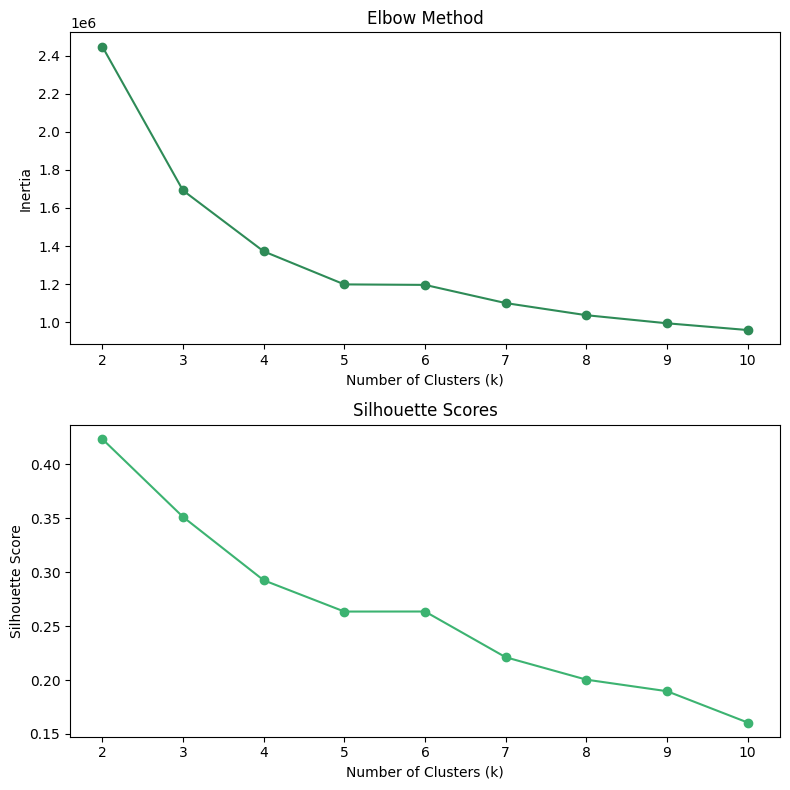

In [ ]:
## Plot
k_values = list(K)
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot 1: Elbow for means
axs[0].plot(k_values, inertias, marker='o', color='seagreen')
axs[0].set_title('Elbow Method')
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('Inertia')


# Plot 2: Silhouette for means
axs[1].plot(k_values, silhouettes, marker='o', color='mediumseagreen')
axs[1].set_title('Silhouette Scores')
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

None of the two graphs show a clear optimal value. Considering the plateau appearing around five and six clusters, the value $k=5$ can be considered as the best tradeoff.

Each cluster groups together users who have similar rating patterns across items. In other words, each user has been assigned to a specific group and now the user can get recommended the most popular items from that group.

### **Clustering process**

In [ ]:
# Clustering: every user is assigned to a cluster
k_clusters = 5
kmeans = KMeans(n_clusters=k_clusters, random_state=42)
user_clusters = kmeans.fit_predict(user_item_filled)
user_cluster_map = pd.Series(user_clusters, index=user_item_filled.index)
print(user_cluster_map)


userId
1       2
10      0
100     3
1000    2
1001    4
       ..
995     0
996     0
997     0
998     0
999     3
Length: 6040, dtype: int32


In [ ]:
# Add cluster assignments to user-item matrix
user_item_with_clusters = user_item_filled.copy()
user_item_with_clusters['cluster'] = user_cluster_map

# Compute average item ratings per cluster
cluster_item_mean = user_item_with_clusters.groupby('cluster').mean()


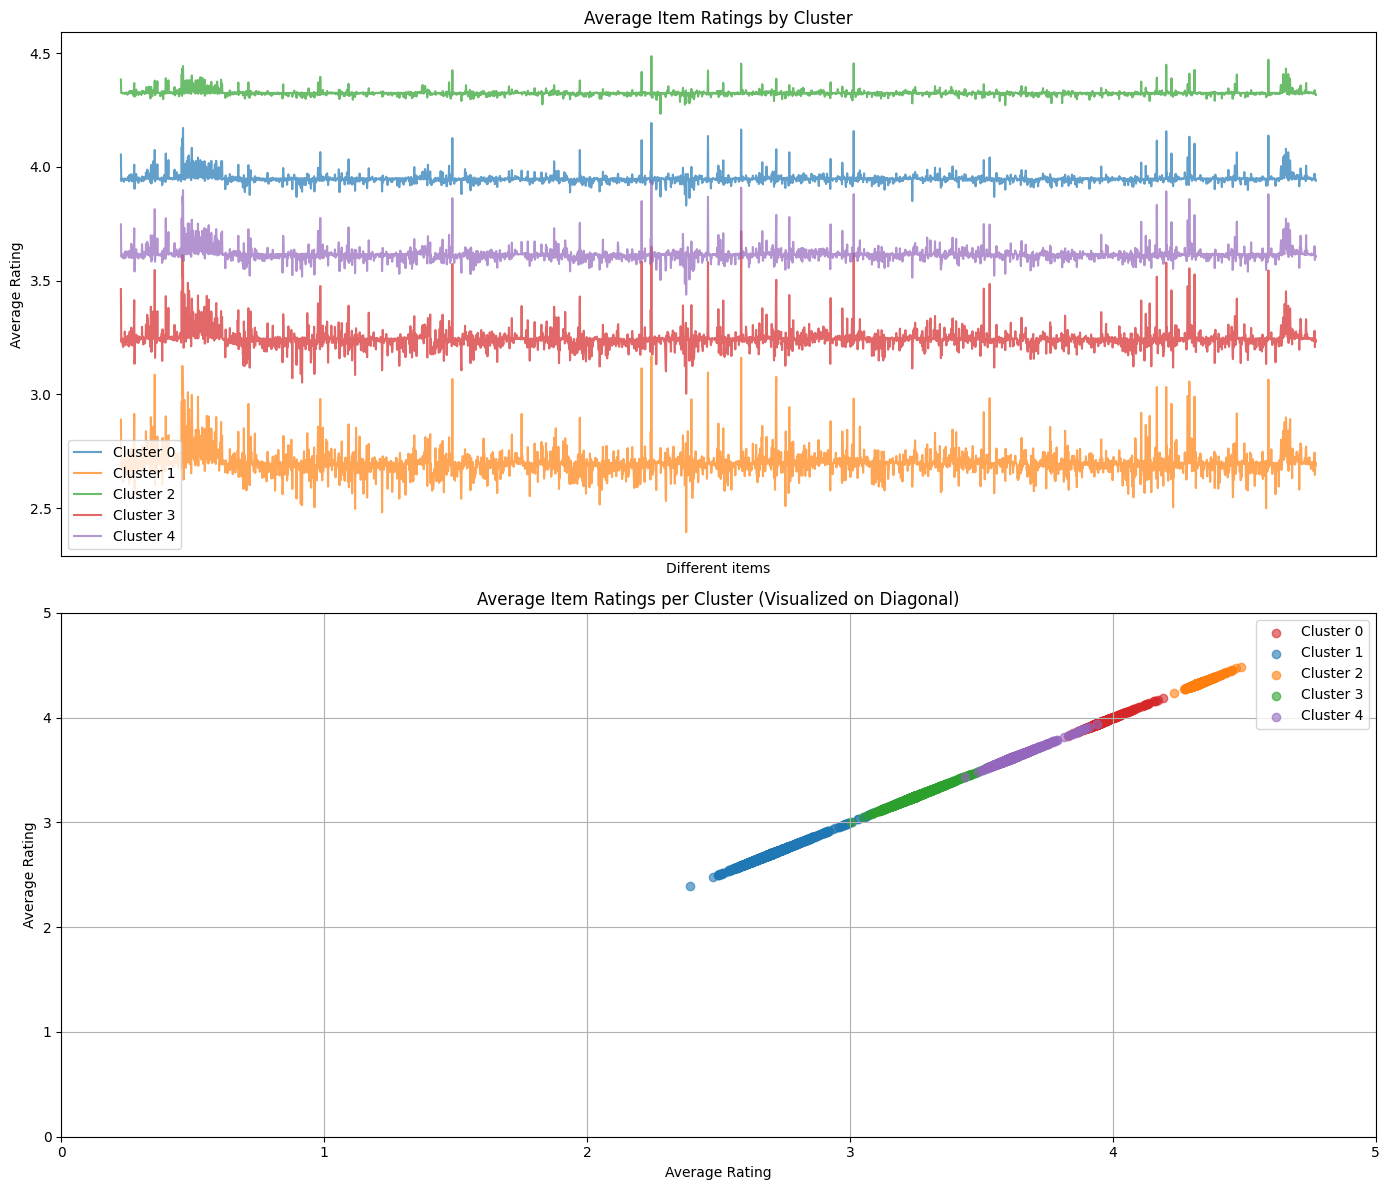

In [ ]:
# Create the subplot figure with 2 rows, 1 column
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

# --- First subplot: Line plot of average item ratings per cluster ---
for cluster_id in cluster_item_mean.index:
    axs[0].plot(cluster_item_mean.columns, cluster_item_mean.loc[cluster_id],
                label=f'Cluster {cluster_id}', alpha=0.7)

axs[0].set_title('Average Item Ratings by Cluster')
axs[0].set_xlabel('Different items')
axs[0].set_ylabel('Average Rating')
axs[0].set_xticks([])  # or customize with item names
axs[0].legend()

# --- Second subplot: Scatter plot of diagonal values for each cluster ---
colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
for cluster_id, color in zip(cluster_item_mean.index, colors):
    mean_ratings = cluster_item_mean.loc[cluster_id]
    axs[1].scatter(mean_ratings.values, mean_ratings.values,
                   c=color, label=f'Cluster {cluster_id}', alpha=0.6)

axs[1].set_title('Average Item Ratings per Cluster (Visualized on Diagonal)')
axs[1].set_xlabel('Average Rating')
axs[1].set_ylabel('Average Rating')
axs[1].set_xlim(0, 5)
axs[1].set_ylim(0, 5)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### **Evaluate the top-N recommendation list for one specific user (e.g. user = 12)**

In [ ]:
def evaluate_top_n_recommendations(user_id, N, threshold,
                                   user_cluster_map, user_item_matrix, test_df):

    # Step 1: Find user's cluster and similar users
    cluster = user_cluster_map[user_id]
    cluster_users = user_cluster_map[user_cluster_map == cluster].index

    # Step 2: Identify items the user hasn't rated
    rated_items = user_item_matrix.loc[user_id].dropna().index
    candidate_items = user_item_matrix.columns.difference(rated_items)

    item_scores = {}
    for item in candidate_items:
        ratings = user_item_matrix.loc[cluster_users, item].dropna()
        if not ratings.empty:
            item_scores[item] = ratings.mean()

    # Step 3: Rank and recommend top-N items
    ranked_items = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)
    top_items = [item for item, score in ranked_items[:N]]

    # Step 4: Evaluate against test set
    user_test_ratings = test_df[test_df['userId'] == user_id]
    liked_items = set(user_test_ratings[user_test_ratings['rating'] >= threshold]['itemId'])
    recommended_items = set(top_items)
    relevant_recommendations = recommended_items.intersection(liked_items)

    precision = len(relevant_recommendations) / N if N > 0 else 0
    recall = len(relevant_recommendations) / len(liked_items) if liked_items else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    # Step 5: Return results
    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    print(f"~ Evaluation of the top-{N} recommendation list of user {user_id} ~")
    print(f"Precision@{N}: {precision:.4f}")
    print(f"Recall@{N}:    {recall:.4f}")
    print(f"F1-Score@{N}:  {f1:.4f}")

    return top_items, metrics


In [ ]:
recommendations, metrics = evaluate_top_n_recommendations(
    user_id='12',
    N=100,
    threshold=4.0,
    user_cluster_map=user_cluster_map,
    user_item_matrix=user_item_matrix,
    test_df=test_df
)


In [ ]:
# Define range of N values
N_values = range(5, 505, 10)

# Store metrics
precision_list = []
recall_list = []
f1_list = []

user_id = '12'
threshold = 4.0

for N in N_values:
    recommendations, metrics = evaluate_top_n_recommendations(
        user_id=user_id,
        N=N,
        threshold=threshold,
        user_cluster_map=user_cluster_map,
        user_item_matrix=user_item_matrix,
        test_df=test_df
    )

    precision_list.append(metrics['Precision'])
    recall_list.append(metrics['Recall'])
    f1_list.append(metrics['F1-Score'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(N_values, precision_list, label="Precision", marker='o')
plt.plot(N_values, recall_list, label="Recall", marker='s')
plt.plot(N_values, f1_list, label="F1-Score", marker='^')
plt.xlabel("Top-N Recommendations")
plt.ylabel("Score")
plt.title(f"Precision / Recall / F1 vs N (User {user_id})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Group test set by user and count how many items each user liked (rating ≥ 4.0)
liked_counts = test_df[test_df['rating'] >= 4.0].groupby('userId')['itemId'].count()

# Filter for users who liked at least 10 items
active_users = liked_counts[liked_counts >= 10].sort_values(ascending=False)

# Show top users
print("Users who liked at least 10 items in the test set:")
print(active_users)


Users who liked at least 10 items in the test set:
userId
4277    312
4169    265
1680    235
3539    185
1015    176
       ... 
1080     10
4586     10
5263     10
2606     10
1366     10
Name: itemId, Length: 3421, dtype: int64


### **Influence of the size and density of the rating matrix**

In [ ]:
def evaluate_subsets(train_df, test_df, nb_users=100, nb_items=100,
                                       N=10, threshold=4.0, k_clusters=5):
    # Subset selection
    unique_users = train_df['userId'].unique()[:nb_users]
    unique_items = train_df['itemId'].unique()[:nb_items]

    small_df = train_df[
        train_df['userId'].isin(unique_users) &
        train_df['itemId'].isin(unique_items)
    ]

    # Create user-item matrix
    user_item_matrix = small_df.pivot(index="userId", columns="itemId", values="rating")

    # Compute sparsity
    num_ratings = user_item_matrix.count().sum()
    sparsity = 1 - (num_ratings / (nb_users * nb_items))
    sparsity = round(sparsity * 100, 2)

    # Fill missing values with user mean
    user_means = user_item_matrix.mean(axis=1)
    user_item_filled = user_item_matrix.T.fillna(user_means).T

    # Cluster users
    kmeans = KMeans(n_clusters=k_clusters, random_state=42)
    user_clusters = kmeans.fit_predict(user_item_filled.fillna(0))
    user_cluster_map = pd.Series(user_clusters, index=user_item_filled.index)

    # Generate recommendations
    recommendations = {}
    for user in user_item_matrix.index:
        cluster = user_cluster_map[user]
        cluster_users = user_cluster_map[user_cluster_map == cluster].index

        rated_items = user_item_matrix.loc[user].dropna().index
        candidate_items = user_item_matrix.columns.difference(rated_items)

        item_scores = {}
        for item in candidate_items:
            ratings = user_item_matrix.loc[cluster_users, item].dropna()
            if not ratings.empty:
                item_scores[item] = ratings.mean()

        ranked_items = sorted(item_scores.items(), key=lambda x: x[1], reverse=True)
        top_items = [item for item, score in ranked_items[:N]]
        recommendations[user] = top_items

    # Filter test set
    filtered_test_df = test_df[
        test_df['userId'].isin(user_item_matrix.index) &
        test_df['itemId'].isin(user_item_matrix.columns)
    ]

    # Evaluate
    test_relevant = defaultdict(set)
    for row in filtered_test_df.itertuples():
        if row.rating >= threshold:
            test_relevant[row.userId].add(row.itemId)

    precisions, recalls, f1s = [], [], []
    for user, rec_items in recommendations.items():
        relevant_items = test_relevant.get(user, set())
        if not relevant_items:
            continue

        true_positives = len(set(rec_items) & relevant_items)
        precision = true_positives / len(rec_items) if rec_items else 0
        recall = true_positives / len(relevant_items)
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)


    # Results
    return {
        "precision": round(np.mean(precisions), 4),
        "recall": round(np.mean(recalls), 4),
        "f1_score": round(np.mean(f1s), 4),
        "sparsity": sparsity
    }


In [ ]:
user_item_range = list(range(50, 1001, 100))

results_list = []

for n in user_item_range:
    res = evaluate_subsets(
        train_df, test_df,
        nb_users=n, nb_items=n,
        N=10, threshold=4.0, k_clusters=5
    )
    res["nb_users"] = n
    res["nb_items"] = n
    results_list.append(res)

results_df = pd.DataFrame(results_list)


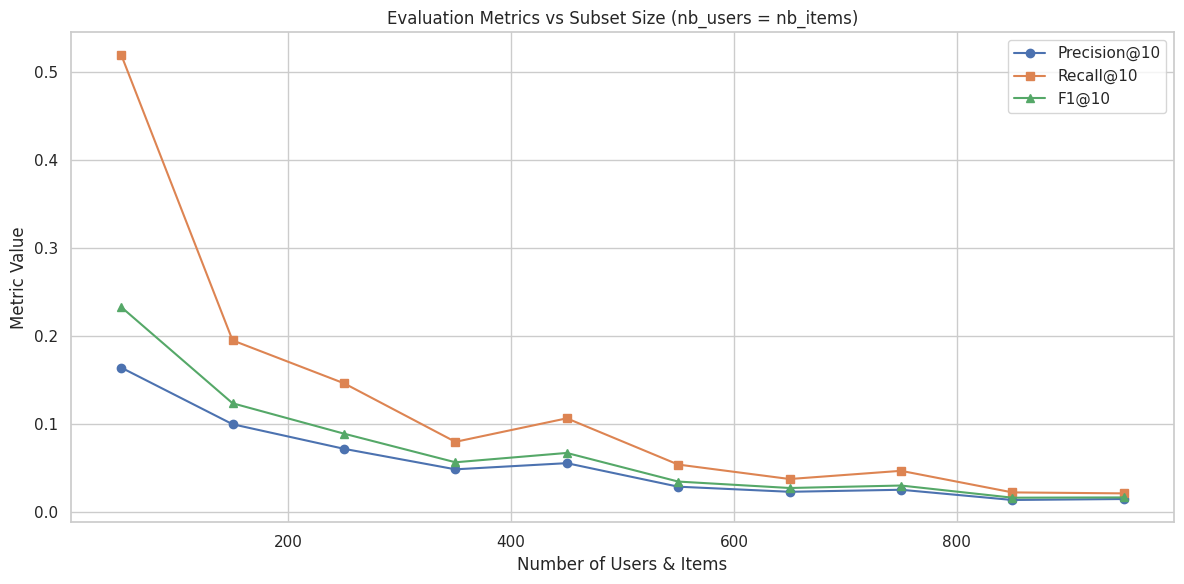

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.plot(results_df["nb_users"], results_df["precision"], label="Precision@10", marker='o')
plt.plot(results_df["nb_users"], results_df["recall"], label="Recall@10", marker='s')
plt.plot(results_df["nb_users"], results_df["f1_score"], label="F1@10", marker='^')

plt.xlabel("Number of Users & Items")
plt.ylabel("Metric Value")
plt.title("Evaluation Metrics vs Subset Size (nb_users = nb_items)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_heatmaps(user_range, item_range):

  heatmap_data = []

  for nb_users in user_range:
      for nb_items in item_range:
          res = evaluate_subsets(
              train_df, test_df,
              nb_users=nb_users,
              nb_items=nb_items,
              N=10,
              threshold=4.0,
              k_clusters=5
          )
          heatmap_data.append({
              "nb_users": nb_users,
              "nb_items": nb_items,
              "precision": res["precision"],
              "recall": res["recall"],
              "f1_score": res["f1_score"],
              "sparsity": res["sparsity"]
          })

  results_df = pd.DataFrame(heatmap_data)

  # Create pivot tables for each metric
  pivot_precision = results_df.pivot(index="nb_users", columns="nb_items", values="precision")
  pivot_recall = results_df.pivot(index="nb_users", columns="nb_items", values="recall")
  pivot_f1 = results_df.pivot(index="nb_users", columns="nb_items", values="f1_score")
  pivot_sparsity = results_df.pivot(index="nb_users", columns="nb_items", values="sparsity")

  # Set up the figure and axes
  fig, axes = plt.subplots(2, 2, figsize=(16, 12))

  # Precision heatmap
  sns.heatmap(pivot_precision, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[0, 0])
  axes[0, 0].set_title("Precision@10")
  axes[0, 0].set_xlabel("Number of Items")
  axes[0, 0].set_ylabel("Number of Users")
  axes[0, 0].invert_yaxis()

  # Recall heatmap
  sns.heatmap(pivot_recall, annot=True, fmt=".2f", cmap="PuBuGn", ax=axes[0, 1])
  axes[0, 1].set_title("Recall@10")
  axes[0, 1].set_xlabel("Number of Items")
  axes[0, 1].set_ylabel("Number of Users")
  axes[0, 1].invert_yaxis()

  # F1-score heatmap
  sns.heatmap(pivot_f1, annot=True, fmt=".2f", cmap="OrRd", ax=axes[1, 0])
  axes[1, 0].set_title("F1-Score@10")
  axes[1, 0].set_xlabel("Number of Items")
  axes[1, 0].set_ylabel("Number of Users")
  axes[1, 0].invert_yaxis()

  # Sparsity heatmap
  sns.heatmap(pivot_sparsity, annot=True, fmt=".2f", cmap="Greys", ax=axes[1, 1])
  axes[1, 1].set_title("Sparsity (%)")
  axes[1, 1].set_xlabel("Number of Items")
  axes[1, 1].set_ylabel("Number of Users")
  axes[1, 1].invert_yaxis()

  plt.tight_layout()
  plt.show()




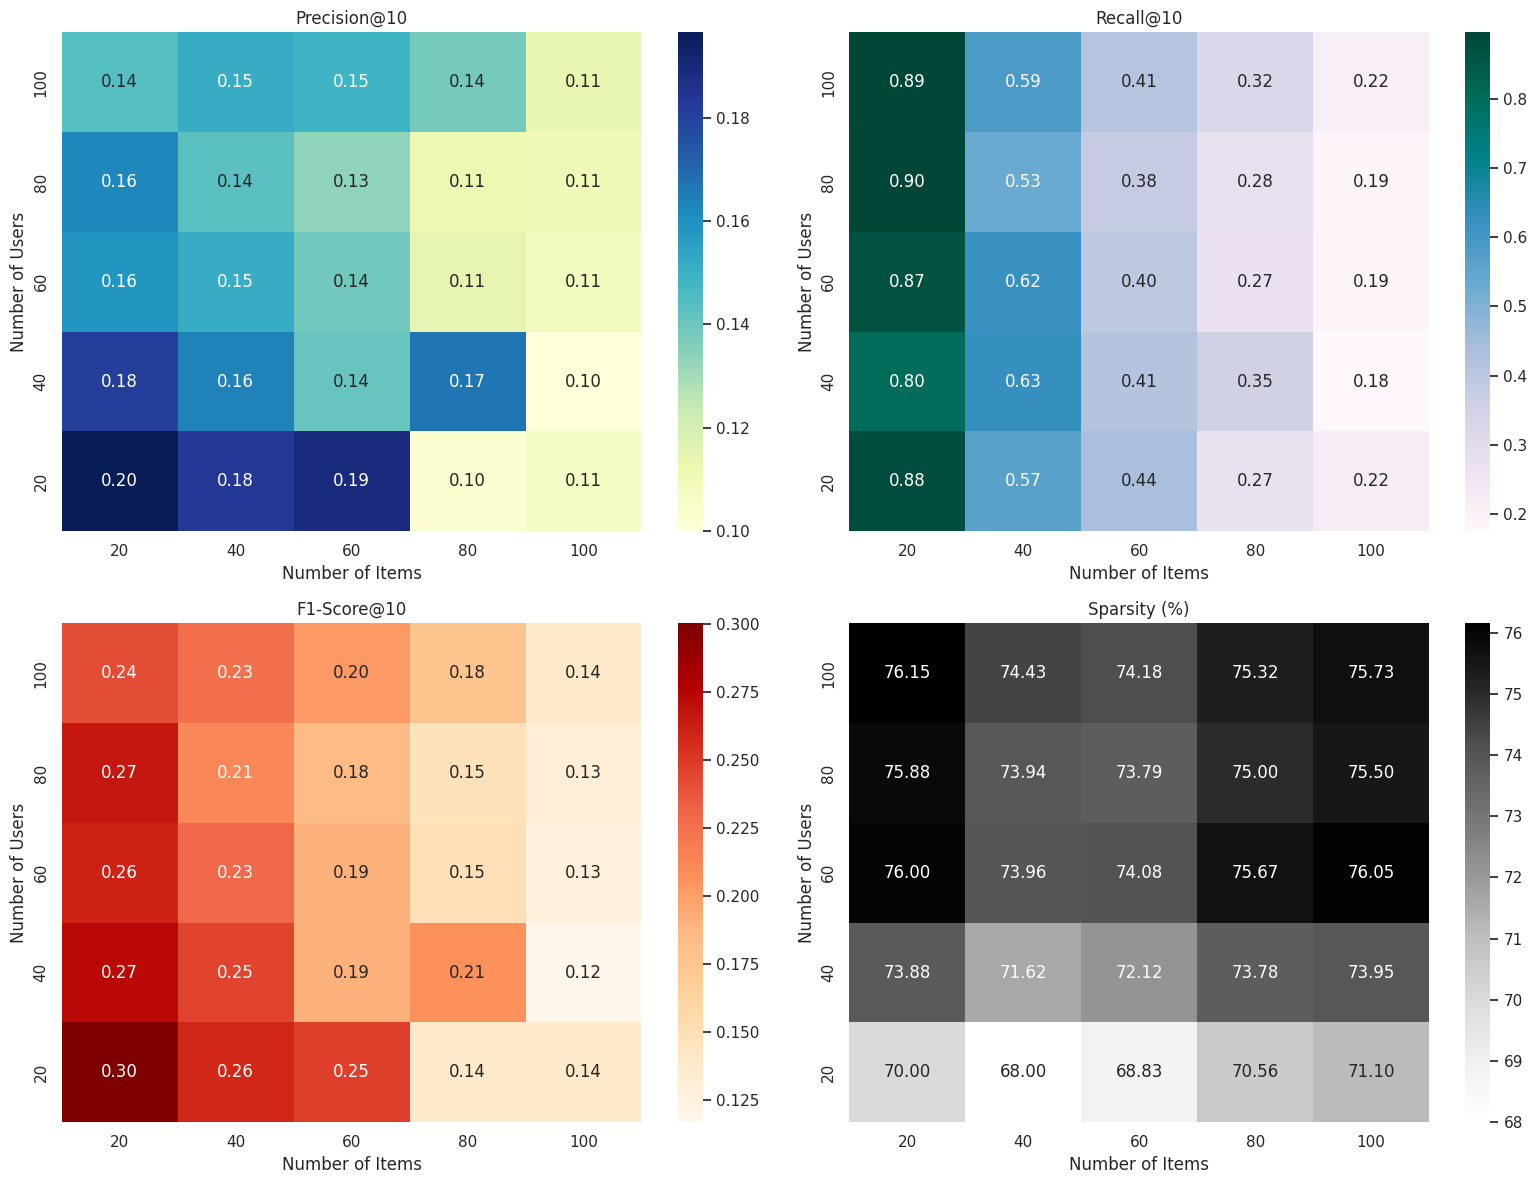

In [ ]:
user_range = [20, 40, 60, 80, 100]
item_range = [20, 40, 60, 80, 100]
display_heatmaps(user_range, item_range)

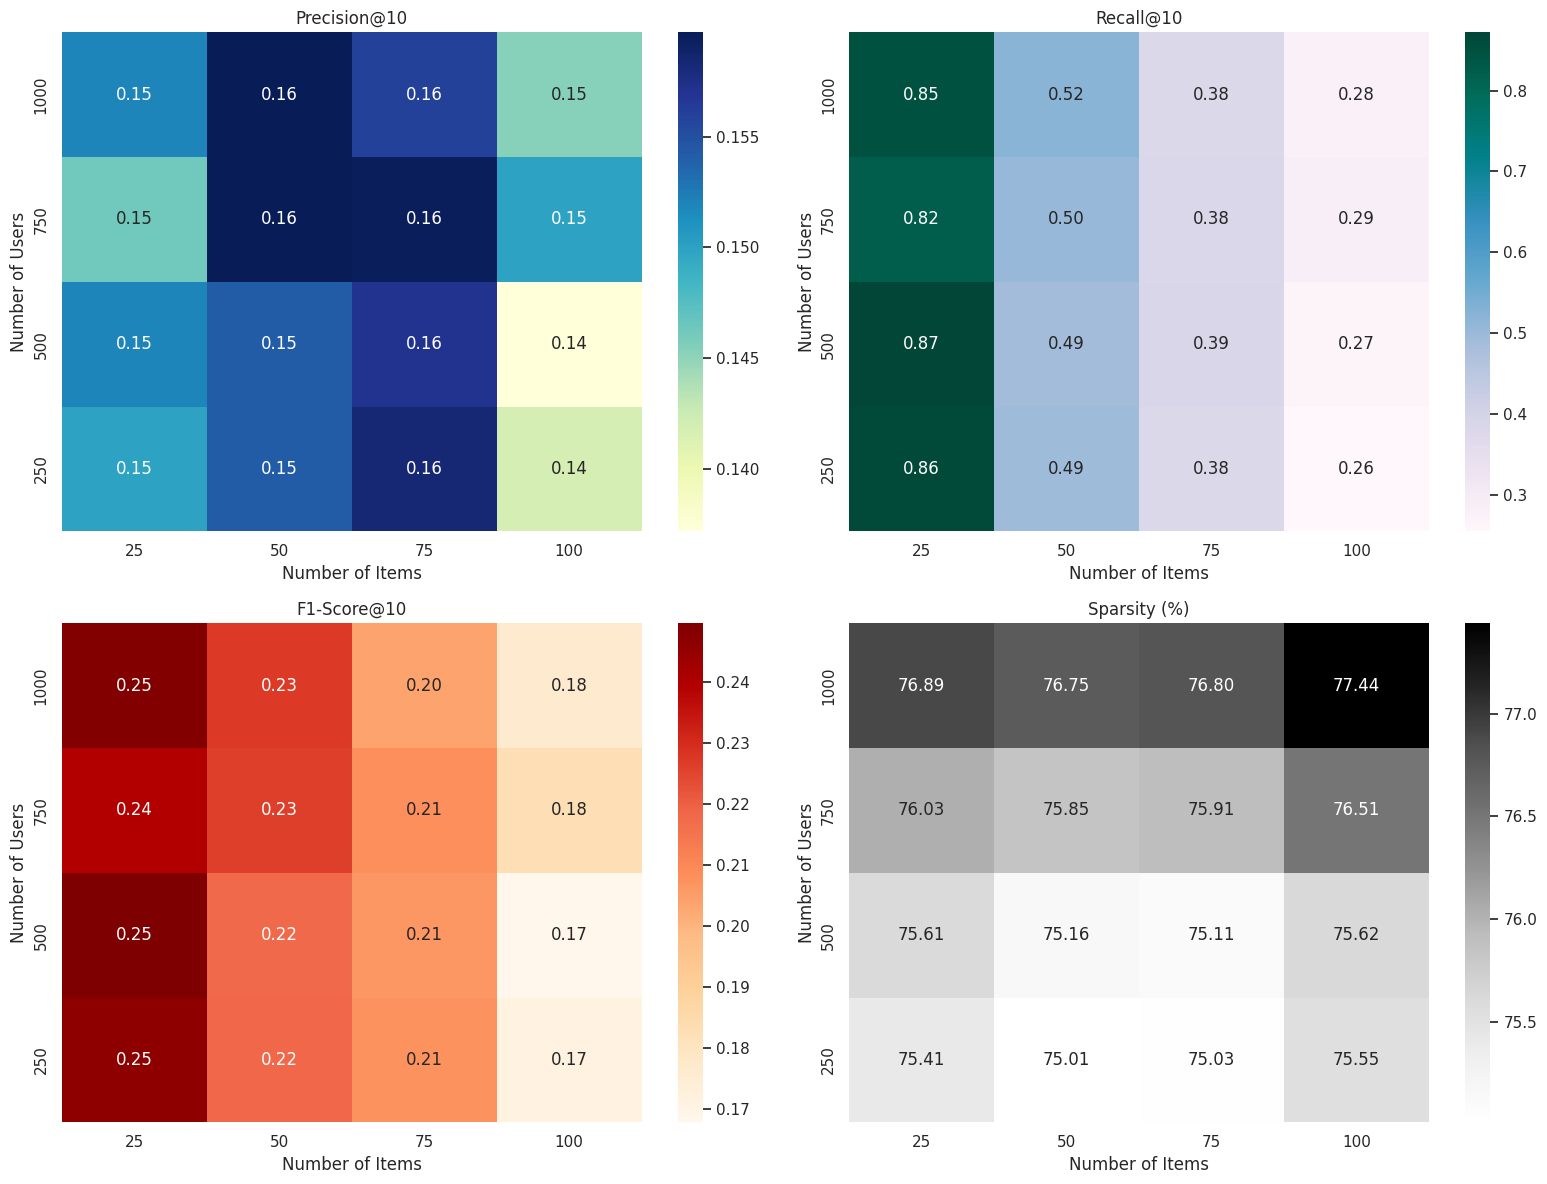

In [ ]:
user_range = [250, 500, 750, 1000]
item_range = [25, 50, 75, 100]
display_heatmaps(user_range, item_range)

# **3. Conclusion**

This experiment provided insight into several common algorithms used in recommender systems.  The comparison between SVD and NMF models showed that both methods offer effective predictions. The SVD model outperformed NMF in the accuracy metrics MAE and RMSE, and was also faster to compute. This suggests that, for this specific dataset and configuration, SVD is more efficient in generalizng user preferences. The K-Means section demonstrated how users were put into different clusters with similar rating patterns. However, this algorithm was significantly affected by the sparsity of the user-item matrix (96.4\%); it showed that computing simple average rating to fill the matrix is not enough to achieve good recommendations, especially for a limited list of items such as in the top-N context where precision matters greatly. Additionally, these experiments highlighted the need for scalable algorithms as a simple K-Means algorithm takes too much time to run on the whole dataset.

Overall, these experimentations particularly demonstrated the need for dimensionality reduction techniques to densify the data into key features. It was initially intended to conclude this experiment with the implementation of a hybrid approach - applying the SVD algorithm before doing K-means. The goal was to observe whether this combination could improve the precision in recommendations compared to a singular K-means model. However, due to time constraints, the hybrid model could not be implemented.
